 # MVPA Per Subject

In [35]:
import numpy as np
import nibabel as nb
import os

In [36]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_08_stability_musicnoise_bold', 'features_full')

In [37]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_features.npy') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_labels.npy') & f.startswith('sub-')]
label_files.sort()

In [38]:
# get number of subjects
n_runs_per_sub = 4
n_subjects = len(dataset_files) / n_runs_per_sub
print('Number of subjects found: %f' % n_subjects)

Number of subjects found: 11.000000


In [39]:
# estimate expected number of rows
# 17 subjects, 8 noise and 9 x 2 music for each of the 4 runs

n_noise_trials = 0
n_noise_splits = 0
n_music_trials = 9*2
n_music_splits = 4

n_rows_estimate_per_run = n_noise_trials*n_noise_splits + n_music_trials*n_music_splits
n_rows_estimate_per_sub = n_runs_per_sub * n_rows_estimate_per_run
n_rows_estimate = n_subjects * n_rows_estimate_per_sub
print(f'Estimated number of rows: {n_rows_estimate}')

Estimated number of rows: 3168.0


In [40]:
# generate an array of chunk labels
chunks = np.repeat(np.arange(1,n_runs_per_sub+1), n_rows_estimate_per_run)
chunks.shape

(288,)

In [41]:
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from sklearn.svm import LinearSVC
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import confusion_matrix

n_classes = 9
class_names = ['JoyfulActivation','Nostalgia','Peacefulness','Power','Sadness','Tenderness','Tension','Transcendence','Wonder']
n_folds = int(n_runs_per_sub)
n_subjects = int(n_subjects)
acc_array = np.zeros((n_subjects,n_folds))
acc_bal_array = np.zeros((n_subjects,n_folds))
confusion_matrix_array = np.zeros((n_subjects,n_classes,n_classes,n_folds))

def process_fold(ss):
    print(f'subject {ss+1}/{n_subjects}...')

    start_idx = (ss+1-1)*n_runs_per_sub
    end_idx = n_runs_per_sub*(ss+1)
    print(f'Selection from {start_idx} to {end_idx}')

    samples = np.concatenate([np.load(f) for f in dataset_files[start_idx:end_idx]], axis=0)
    labels = np.concatenate([np.load(f, allow_pickle=True) for f in label_files[start_idx:end_idx]], axis=0)

    acc = np.zeros(n_folds)
    acc_bal = np.zeros(n_folds)
    cm = np.zeros((n_classes,n_classes,n_folds))

    for ff in range(n_folds):
        print(f'fold {ff+1}/{n_folds}...')

        clf = LinearSVC(multi_class="ovr", max_iter=5000, class_weight='balanced', dual='auto')
        
        # split the data into training and test set
        train_mask = chunks != ff+1
        test_mask = chunks == ff+1

        X_train = samples[train_mask, :]
        y_train = labels[train_mask]
        X_test = samples[test_mask, :]
        y_test = labels[test_mask]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Compute the prediction accuracy for the different labels
        acc[ff] = (y_pred == y_test).mean()
        acc_bal[ff] = balanced_accuracy_score(y_test, y_pred)

        #print(clf.classes_)

        # confusion matrix
        cm[...,ff] = confusion_matrix(y_test, y_pred, normalize='true')

    return ss, acc, acc_bal, cm

with ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(process_fold, range(int(n_subjects))))

# Update the accuracy arrays with the results
for ss, acc, acc_bal, cm in results:
    acc_array[ss,:] = acc
    acc_bal_array[ss,:] = acc_bal
    confusion_matrix_array[ss,...] = cm

subject 1/11...
Selection from 0 to 4
subject 2/11...
Selection from 4 to 8
subject 3/11...
Selection from 8 to 12
subject 4/11...
Selection from 12 to 16
fold 1/4...
fold 1/4...
fold 1/4...
fold 1/4...
fold 2/4...
fold 2/4...
fold 3/4...
fold 2/4...
fold 4/4...
fold 3/4...
fold 2/4...
subject 5/11...
Selection from 16 to 20
fold 1/4...
fold 3/4...
fold 4/4...
fold 2/4...
subject 6/11...
Selection from 20 to 24
fold 1/4...
fold 3/4...
fold 4/4...
fold 3/4...
fold 4/4...
subject 7/11...
Selection from 24 to 28
fold 1/4...
subject 8/11...
Selection from 28 to 32
fold 2/4...
fold 1/4...
fold 2/4...
fold 4/4...
fold 2/4...
fold 3/4...
fold 3/4...
fold 4/4...
fold 4/4...
fold 3/4...
subject 9/11...
Selection from 32 to 36
fold 1/4...
subject 10/11...
Selection from 36 to 40
fold 1/4...
fold 2/4...
fold 2/4...
subject 11/11...
Selection from 40 to 44
fold 1/4...
fold 3/4...
fold 4/4...
fold 3/4...
fold 4/4...
fold 4/4...
fold 2/4...
fold 3/4...
fold 4/4...


In [42]:
m_s = np.mean(np.mean(acc_array,1))*100
s_s = np.std(np.mean(acc_array,1))*100
m_b_s = np.mean(np.mean(acc_bal_array,1))*100
s_b_s = np.std(np.mean(acc_bal_array,1))*100

In [43]:
print(f"Mean accuracy across subs: {m_s:0.1f}% \u00B1 {s_s:0.1f}%")
print(f"Mean balanced accuracy across subs: {m_b_s:0.1f}% \u00B1 {s_b_s:0.1f}%")

Mean accuracy across subs: 23.6% ± 5.0%
Mean balanced accuracy across subs: 23.6% ± 5.0%


In [44]:
M = np.mean(np.mean(confusion_matrix_array,3),0)*100

M_annot = []

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        aux = f'{M[i, j]:0.1f}%'
        M_annot.append(aux)

M_annot_plot =  np.array(M_annot).reshape(M.shape)

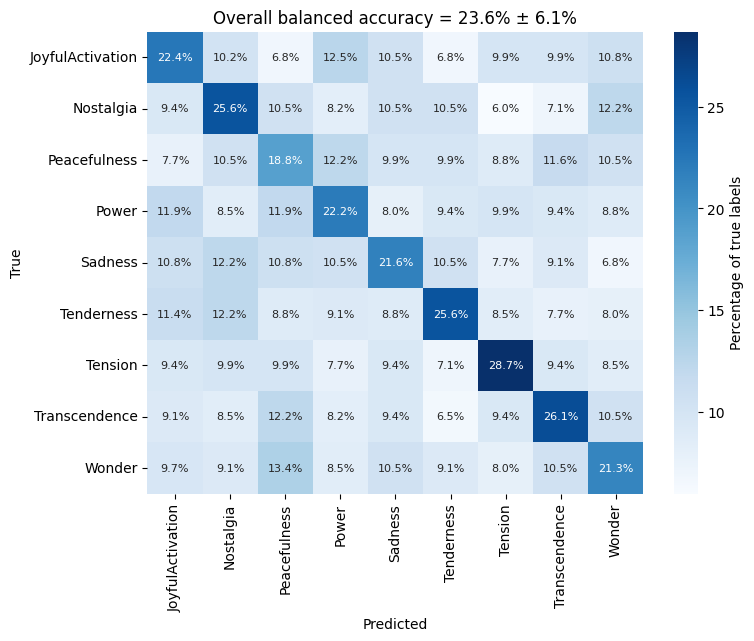

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(M, annot=M_annot_plot, fmt = '', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, 
            annot_kws={"size": 8},
            cbar_kws={'label': 'Percentage of true labels'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Overall balanced accuracy = {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%')
plt.show()